In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from sklearn.metrics import mean_squared_error
import pmdarima
from pmdarima import auto_arima
from composition_stats import closure
from composition_stats import ilr,ilr_inv
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os 
  
# current directory 
current_dir = os.getcwd() 
relative_path=os.path.abspath(os.path.join(current_dir, os.pardir))

In [3]:
ILR_data = pd.DataFrame(pd.read_csv(
    relative_path+"\\age_structure_data\\ILR_data.csv"))
ILR_data['Year'] = pd.to_datetime(ILR_data['Year'])
ILR_data =ILR_data.set_index("Year")

In [4]:
test_data= pd.DataFrame(pd.read_csv(
    relative_path+"\\age_structure_data\\df_test.csv"))
test_data['Year'] = pd.to_datetime(test_data['Year'])
test_data = test_data.set_index("Year")

In [5]:
Transfomed_ILR_1=ILR_data['log_ratio_1']
Transfomed_ILR_2=ILR_data['log_ratio_2']

In [6]:
def find_best_pdq(train_data, test_data, d):
    df_search = pd.DataFrame()
    for p in range(6):
            for q in range(6):
                arima_model = ARIMA(train_data, order=(p, d, q)).fit()
                # predict from the position of test data which is length of train data
                prediction = arima_model.predict(
                    start=len(train_data), end=len(train_data)+len(test_data)-1)
                rmse = sqrt(mean_squared_error(test_data, prediction))
                df_search = df_search.append({'pdq_paramters': str(
                    p)+" "+str(d)+" "+str(q), 'rmse': rmse}, ignore_index=True)
    return df_search, test_data, prediction

For Transfomed_ILR_1

In [7]:
train_1_1, test_1_1 = train_test_split(Transfomed_ILR_1, test_size=0.2, shuffle=False)
train_1_2, test_1_2 = train_test_split(train_1_1, test_size=0.2, shuffle=False)
train_1_3, test_1_3 = train_test_split(train_1_2, test_size=0.15, shuffle=False)
log_ratio1_best_pdq1, test_data1_1, prediction_test1_1=find_best_pdq(train_1_1, test_1_1, 2)
log_ratio1_best_pdq2, test_data1_2, prediction_test1_2=find_best_pdq(train_1_2, test_1_2, 2)
log_ratio1_best_pdq3, test_data1_3, prediction_test1_3=find_best_pdq(train_1_3, test_1_3, 2)

concatenated_1 = pd.concat([log_ratio1_best_pdq1, log_ratio1_best_pdq2, log_ratio1_best_pdq3])
concatenated_1=concatenated_1.groupby('pdq_paramters').mean()
concatenated_1.sort_values('rmse', ascending=True).head()

,rmse
pdq_paramters,
2 2 2,0.014059
3 2 4,0.026706
4 2 4,0.027534
2 2 4,0.027836
5 2 4,0.028019


In [8]:
arima_model_1 = ARIMA(Transfomed_ILR_1, order=(2, 2, 2)).fit()
prediction_1 = arima_model_1.predict(
    start=len(Transfomed_ILR_1), end=len(Transfomed_ILR_1)+len(test_data)-1)
prediction_1 = prediction_1.to_frame()
prediction_1.rename(columns = {'predicted_mean':0}, inplace = True)
final_1 = pd.concat([Transfomed_ILR_1, prediction_1])

For Transfomed_ILR_2

In [9]:
train_2_1, test_2_1 = train_test_split(Transfomed_ILR_2, test_size=0.2, shuffle=False)
train_2_2, test_2_2 = train_test_split(train_2_1, test_size=0.2, shuffle=False)
train_2_3, test_2_3 = train_test_split(train_2_2, test_size=0.15, shuffle=False)
log_ratio2_best_pdq1, test_data2_1, prediction_test2_1=find_best_pdq(train_2_1, test_2_1, 2)
log_ratio2_best_pdq2, test_data2_2, prediction_test2_2=find_best_pdq(train_2_2, test_2_2, 2)
log_ratio2_best_pdq3, test_data2_3, prediction_test2_3=find_best_pdq(train_2_3, test_2_3, 2)

concatenated_2 = pd.concat([log_ratio2_best_pdq1, log_ratio2_best_pdq2, log_ratio2_best_pdq3])
concatenated_2=concatenated_2.groupby('pdq_paramters').mean()
concatenated_2.sort_values('rmse', ascending=True).head()

,rmse
pdq_paramters,
2 2 4,0.017354
3 2 4,0.018855
4 2 3,0.019023
1 2 4,0.019520
0 2 3,0.019598


In [10]:
arima_model_2 = ARIMA(Transfomed_ILR_2, order=(2, 2, 4)).fit()
prediction = arima_model_2.predict(
    start=len(Transfomed_ILR_2), end=len(Transfomed_ILR_2)+len(test_data)-1)
prediction = prediction.to_frame()
prediction.rename(columns = {'predicted_mean':0}, inplace = True)
final_2 = pd.concat([Transfomed_ILR_2, prediction])

Combine parts

In [11]:
final_1.rename(columns = {0:'log_ratio1'}, inplace = True)
final_2.rename(columns = {0:'log_ratio2'}, inplace = True)
final = pd.concat([final_1, final_2], axis=1)
proportion=ilr_inv(final)
proportion = pd.DataFrame(proportion, columns=[
    'elder', 'youth', 'kid'])
proportion['Year'] = proportion.index + 1964
proportion['Year'] = pd.to_datetime(proportion['Year'], format='%Y')
proportion = proportion.set_index("Year")

In [12]:
df_actual=proportion[(proportion.index< '2010-01-01')]
df_forecast=proportion[(proportion.index> '2009-01-01')]

In [13]:
actual_test1 = pd.concat([test_data1_1, test_data2_1], axis=1)
actual_test2 = pd.concat([test_data1_2, test_data2_2], axis=1)
actual_test3 = pd.concat([test_data1_3, test_data2_3], axis=1)
forecast_test1 = pd.concat([prediction_test1_1, prediction_test2_1], axis=1)
forecast_test2 = pd.concat([prediction_test1_2, prediction_test2_2], axis=1)
forecast_test3 = pd.concat([prediction_test1_3, prediction_test2_3], axis=1)
proportion_actual_1=ilr_inv(actual_test1)
proportion_actual_2=ilr_inv(actual_test2)
proportion_actual_3=ilr_inv(actual_test3)
proportion_forecast_1=ilr_inv(forecast_test1)
proportion_forecast_2=ilr_inv(forecast_test2)
proportion_forecast_3=ilr_inv(forecast_test3)

In [14]:
rmse1 = sqrt(mean_squared_error(proportion_actual_1, proportion_forecast_1))
rmse2 = sqrt(mean_squared_error(proportion_actual_2, proportion_forecast_2))
rmse3 = sqrt(mean_squared_error(proportion_actual_3, proportion_forecast_3))

rmse_cv=(rmse1+rmse2+rmse3)/3
rmse_cv

0.0022110655186604114

In [15]:
rmse_final = sqrt(mean_squared_error(df_forecast, test_data))
rmse_final

0.006379231136732239

In [16]:
df_forecast.to_csv(relative_path+"\\age_structure_data\\grid_ILR_forecast.csv")

<function matplotlib.pyplot.show(close=None, block=None)>

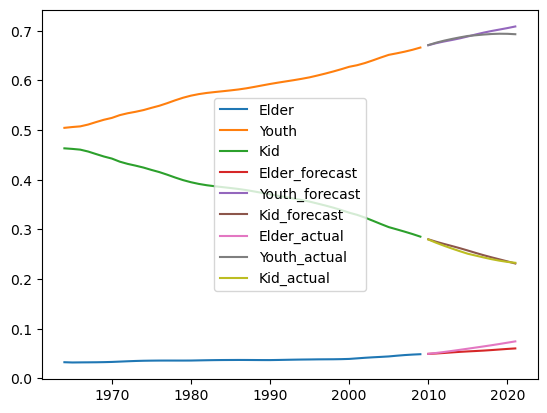

In [17]:
plt.plot(df_actual['elder'],label="Elder")
plt.plot(df_actual['youth'],label="Youth")
plt.plot(df_actual['kid'],label="Kid")
plt.plot(df_forecast['elder'],label="Elder_forecast")
plt.plot(df_forecast['youth'],label="Youth_forecast")
plt.plot(df_forecast['kid'],label="Kid_forecast")

plt.plot(test_data['elder'],label="Elder_actual")
plt.plot(test_data['youth'],label="Youth_actual")
plt.plot(test_data['kid'],label="Kid_actual")


plt.legend(loc='best')
plt.show